EE 502 P: Analytical Methods for Electrical Engineering
# 10. Machine Learning, Part II
## Prof. Eric Klavins, Electrical and Computer Engineering

### Tamara Bonaci, Department of Electrical and Computer Engineering
### December 8, 2021
Copyright &copy; 2021, University of Washington


In [1]:
import sys
import math
import random
import scipy # Has linear algebra
import scipy.ndimage
import numpy as np
import sympy as sm
sm.init_printing(use_latex='mathjax')
import matplotlib.pyplot as plt
import matplotlib.patches as pch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import pandas as pd;

%matplotlib inline

# Image Recognition

Neural Networks have seen great success in image recognition, where the input is an image represented as a matrix or tensor (if it has RBG values, for example), and the output is a class (such as cat, dog, etc). 

One issue that comes up with images is that when the input is an $n \times n$ matrix and the next layer is a dense layer with $m$ nodes, you get $n^2m$ connections, which can be quite big. Furthermore, such an arrangement would loose adjacency relationships. 

To get around this, most NNs use convolutional layers in which a small kernel is convolved with the image. A $k \timex k$ kernel itself only has a $k^2$ parameters, and usually $k$ is 3, 5 or 7. In this way, many layers of image processing can be put into a NN without very many parameters.

<img src="https://cdn-media-1.freecodecamp.org/images/Gjxh-aApWTzIRI1UNmGnNLrk8OKsQaf2tlDu" width=70%>

In [5]:
# Get an image and convert it to a tensor. The result is a
# 372 x 425 matrix.
import imageio
m = imageio.imread('images/minion.jpg',as_gray=True)
m = torch.tensor(m)

# The image processing networks provided by pytorch expect a list of 
# c x n x m matrices where c is the number of channels (1 for grayscale, 3 for RGB),
# and n,m are the dimensions of the image. The following converts m to the
# proper dimensions

m = m.unsqueeze(0).unsqueeze(0)
m.shape

FileNotFoundError: ignored

In [ ]:
# Example of a convolution using pytorch.

# Define a (randomly initialized) convolution
# The network will learn parameters that pick out relevant
# features
conv = nn.Conv2d(1, 1, kernel_size=5)

print([p for p in conv.parameters()])

# Apply it to the image
new_m = conv(m)

fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(m[0][0],cmap="gray")
ax[1].imshow(new_m.detach()[0][0],cmap="gray");

# Further processing

Once a convolution is applied, one then typically applies a nonlinearity, such as and RLU.

To make the output to downstream layers smaller, and reduce the size of the data flowing through the network, many networks apply pooling. For example, you can perform a max pool of the form:

<img src="https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png" width=50%>

In [8]:
# Apply a convolution, a nonlinearity, and maxpooling

conv = nn.Conv2d(1, 1, kernel_size=5)
relu = nn.ReLU()
maxpool = nn.MaxPool2d(2)
new_m = maxpool(relu(conv(m)))

fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].imshow(m[0][0],cmap="gray")
ax[1].imshow(new_m.detach()[0][0],cmap="gray");

NameError: ignored

# Applying Multiple Channels and Layers

* **Padding**: A 5x5 kernel will shrink an image by 2 pixels on each edge. Adding padding, usually zeros, keeps the image size the same, but does add an artifact of an edge to the image. 

* **Channels**: Kernels typically are $k \times k \times c$ where $c$ is a number of channels. An 1 x n x m gray-scale input might be through a 5 x 5 x 16 kernel to get a 16 x (n-4) x (m-4) image. In the image, the boxes below get wider and wider, indicating that the number of channels is increasing while the dimensions of each channel are shrinking. The goal is to make it so that *some* channel has a chance of recognizing some feature of the image.

* **Layers:** A big NN will usually have 2 to 10 layers with convolutions, a nonlinearity, and max pooling at each layer. Then two or more linear layers are added at the end.

<img src="https://qph.fs.quoracdn.net/main-qimg-91bed3a2c685043b60d52fc3b52c8b1f" width=60%>

# Batch Normalization

A network with multiple layers has the following problem: The output of layer $n$, even on the same data, may change considerably during training as the parameters are tuned. This means that layer $n+1$ is seeing what looks like totally new data at each step.

To fix this, we normalize the output of each layer using **batch normalization** (see [here](https://arxiv.org/pdf/1502.03167.pdf)). If $x_1, ..., x_m$ are a batch of data, then to batch normalize it we find its mean $\mu$ and its variance $\sigma^2$. Then we normalize the data with

$$
\hat x_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}
$$

and then scale and shift the data to get a new output

$$
y_i = \gamma x_i + \beta .
$$

The parameters $\gamma$ and $\beta$ are then learnable. The means and variances of the output now become *independent* of the data being sent in, which decouples the learning problem for each layer!

In [7]:
# Here is a convolutional neural network that has two convolutional layers
# and one fully connected layer. This network can be found in the pytorch 
# tutorials.

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Example classification problems

To explore how neural networks work, and how to tune them, researchers use example data sets. Kaggle is a source of such data, and is a subsidiary of Google. In fact, it holds competitions that anyone can enter to try to do various ML problems with their data.

For this lecture, we'll use the Fashion MNIST dataset available through Kaggle. It includes 70,000 images, each gray-scale and 28x28, and each labeled as either
- T-shirt/top
- Trouser
- Pullover
- Dress
- Coat
- Sandal
- Shirt
- Sneaker
- Bag
- Ankle boot

<img src="https://s3-eu-central-1.amazonaws.com/zalando-wp-zalando-research-production/2017/08/fashion-mnist-sprite.png">

In [ ]:
# We first load the data

class FashionMNISTDataset(Dataset):
    '''Fashion MNIST Dataset'''
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file
            transform (callable): Optional transform to apply to sample
        """
        
        data = pd.read_csv(csv_file);
        self.X = np.array(data.iloc[:, 1:]).reshape(-1, 1, 28, 28)#.astype(float);
        self.Y = np.array(data.iloc[:, 0]);
        
        del data;
        self.transform = transform;
        
    def __len__(self):
        return len(self.X);
    
    def __getitem__(self, idx):
        item = self.X[idx];
        label = self.Y[idx];
        
        if self.transform:
            item = self.transform(item);
        
        return (item, label);
    
meanings = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
];

train_dataset = FashionMNISTDataset(csv_file='fashionmnist/fashion-mnist_train.csv')
test_dataset = FashionMNISTDataset(csv_file='fashionmnist/fashion-mnist_test.csv')

In [9]:
len(train_dataset), len(test_dataset)

NameError: ignored

In [ ]:
# Here, we show 9 random images, their indices, and labels. 

fig,ax=plt.subplots(3,3,figsize=(9,9))

for k in range(9):
    n = random.randint(0,len(train_dataset))
    x,y = train_dataset[n]
    i,j = k%3, int(k/3)
    ax[i][j].imshow(x[0],cmap="gray")
    ax[i][j].set_title("%d: %s" % (n,meanings[y]));
    ax[i][j].axis('off');

In [ ]:
# Here we use a pytorch utility that can stream the images to us in batches, with the images
# shuffled each time we complete a run through the data set.

batch_size = 100

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True);
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True);

In [ ]:
# Test the randomly initialized network to see how well it predicts the
# test set of 10,000 images.

cnn = CNN()
criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001);

cnn.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.float())
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('Initial test accuracy of the model on the 10000 test images: %.4f %%' % (100 * correct / total))

In [ ]:
# Now train the network.
cnn.train() # switches modes

# Look at the entire training set 10 times
num_epochs = 10

losses = [];
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.float())
        labels = Variable(labels)
        
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        losses.append(loss);
        if (i+1) % 100 == 0:
            
            sys.stdout.write('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f        \r' 
                            %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss))

In [ ]:
# Switch the network to evaluation mode and 
# see how well it predicts the training set.

cnn.eval()
correct = 0
total = 0
for images, labels in train_loader:
    images = Variable(images.float())
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('Test Accuracy of the model on the 60000 test images: %.4f %%' % (100 * correct / total))

In [ ]:
# Visualizing Internal Layers

batch_size = 2

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True);

images, _ = next(iter(train_loader)) 
images = Variable(images.float())

z1 = cnn.layer1(images)
z2 = cnn.layer2(z1)

In [3]:
plt.imshow(images.detach()[0][0], cmap="gray");

NameError: ignored

NameError: ignored

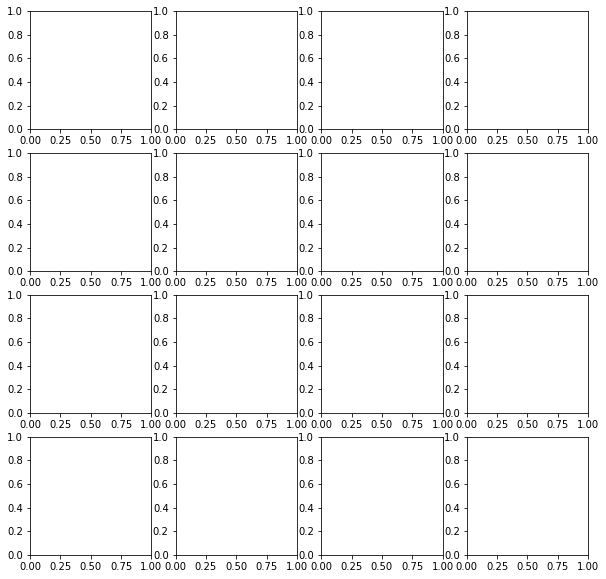

In [4]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(4,4, figsize=(10,10))

for i in range(16):
    ax[i%4][i//4].imshow(z1[0][i].detach())

In [ ]:
fig,ax = plt.subplots(4,8, figsize=(12,6))

for i in range(32):
    ax[i%4][i//4].imshow(z2[0][i].detach())